In [1]:
import torch
import torch.nn as nn
import numpy as np
from dreamsdm.models import ResNet18
from dreamsdm.datasets.wdmgal import Galaxies, GalaxiesCombined
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

GAS MAPS 

In [2]:
img_dir_train =  "/mnt/ceph/users/dmohan/dreams/data/gasmaps/train/File_"
img_dir_val =  "/mnt/ceph/users/dmohan/dreams/data/gasmaps/val/File_"
img_dir_test = "/mnt/ceph/users/dmohan/dreams/data/gasmaps/test/File_"
mu = 0.9676
sigma = 0.0730
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = mu, std = sigma)
                                ])
# valset = WDMGalaxies(img_dir_val, n_files = 100, n_gal = 2)
valset = Galaxies(img_dir_val, n_files = 100, n_gal = 10, transform = transforms)
testset = Galaxies(img_dir_test, n_files = 100, n_gal = 10, transform = transforms)

input_size = (1, 512, 512)

COMBINED MAPS

In [2]:
img_dir_train =  "/mnt/ceph/users/dmohan/dreams/data/combinedmaps/train/File_"
img_dir_val =  "/mnt/ceph/users/dmohan/dreams/data/combinedmaps/val/File_"
img_dir_test = "/mnt/ceph/users/dmohan/dreams/data/combinedmaps/test/File_"
mu = (0.9676, 0.9738)
sigma = (0.0730, 0.0493)
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = mu, std = sigma)
                                ])
valset = GalaxiesCombined(img_dir_val, n_files = 100, n_gal = 10, transform = transforms)
testset = GalaxiesCombined(img_dir_test, n_files = 100, n_gal = 10, transform = transforms)
input_size = (2, 512, 512)

In [59]:
val_dataloader = DataLoader(valset, batch_size=32, shuffle=False, num_workers = 32, prefetch_factor= 4, drop_last = False)
test_dataloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers = 32, prefetch_factor= 4, drop_last = False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)

model = ResNet18(img_dim = input_size, output_size = 4).to(device)

criterion = nn.MSELoss()

In [33]:
# results_path = '/mnt/ceph/users/dmohan/dreams/results/gasmaps/exp4/best_model.pt'
results_path = '/mnt/ceph/users/dmohan/dreams/results/combinedmaps/exp4/best_model.pt'


In [34]:

checkpoint = torch.load(results_path, weights_only=True)
model.load_state_dict(checkpoint) #['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# train_loss = checkpoint['training loss']
# val_loss = checkpoint['val loss']

# print("Epoch:", epoch, "Train loss:", train_loss, "Val Loss:", val_loss)



<All keys matched successfully>

In [60]:
from sklearn.metrics import r2_score
running_loss = 0.0
y_pred = []
y_true = []

print(len(testset))
# output = torch.zeros(len(testset))
# y_val_all = torch.zeros(len(testset))

with torch.no_grad():
    for i, (x_val, y_val) in enumerate(test_dataloader):
        x_val, y_val = x_val.to(device), y_val.to(device)
        outputs = model(x_val)
        y_pred.append(outputs.to(torch.double))
        y_true.append(y_val)
        loss = criterion(outputs.to(torch.double), y_val)
        loss_wdm = criterion(outputs.to(torch.double)[:, 0], y_val[:, 0])
        loss_agn = criterion(outputs.to(torch.double)[:, 1], y_val[:, 1])
        loss_sn1 = criterion(outputs.to(torch.double)[:, 2], y_val[:, 2])
        loss_sn2 = criterion(outputs.to(torch.double)[:, 3], y_val[:, 3])
        # print(outputs.to(torch.double).shape, y_val.shape)
        running_loss += loss.item()
        
r2_ = r2_score(torch.cat(y_true).cpu().detach().numpy(), torch.cat(y_pred).cpu().detach().numpy(), multioutput = 'raw_values')

print(running_loss/(i+1))


1000
1.3219533559220642


In [43]:
loss_sn2

tensor(0.0485, device='cuda:0', dtype=torch.float64)

In [6]:
r2_score([1.3, 2.5], [1.3, -2.5])

-33.72222222222222

In [61]:
wdm_pred = torch.cat(y_pred)[:, 0].cpu().detach().numpy()
wdm_true = torch.cat(y_true)[:, 0].cpu().detach().numpy()

agn_pred = torch.cat(y_pred)[:, 1].cpu().detach().numpy()
agn_true = torch.cat(y_true)[:, 1].cpu().detach().numpy()

sn1_pred = torch.cat(y_pred)[:, 2].cpu().detach().numpy()
sn1_true = torch.cat(y_true)[:, 2].cpu().detach().numpy()

sn2_pred = torch.cat(y_pred)[:, 3].cpu().detach().numpy()
sn2_true = torch.cat(y_true)[:, 3].cpu().detach().numpy()

In [62]:
np.set_printoptions(precision = 4)
wdm_r2 = np.round(r2_[0], 4)
agn_r2 = np.round(r2_[1], 4)
sn1_r2 = np.round(r2_[2], 4)
sn2_r2 = np.round(r2_[3], 4)
save_fig = False
dpi =200
fig_name = '_test_small.png'


In [63]:
print(wdm_r2, agn_r2, sn1_r2, sn2_r2)

-25.3752 -0.8595 -1.078 -2.1388


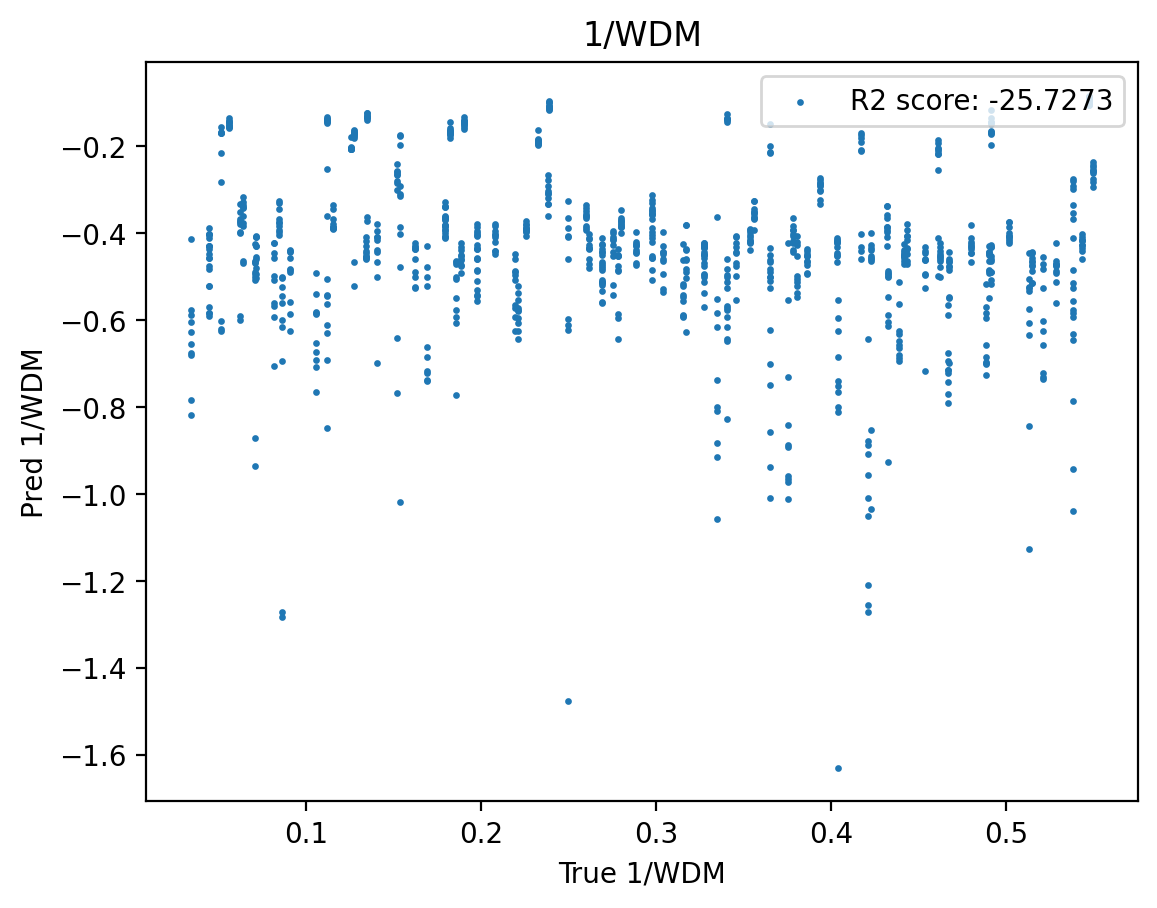

In [54]:

plt.figure(dpi = dpi)
plt.scatter(wdm_true, wdm_pred, s = 2, label = f"R2 score: {wdm_r2}")
plt.xlabel("True 1/WDM")
plt.ylabel("Pred 1/WDM")
plt.title(f"1/WDM")
plt.legend(loc = 'upper right')
if(save_fig == True):
    plt.savefig('wdm' + fig_name)

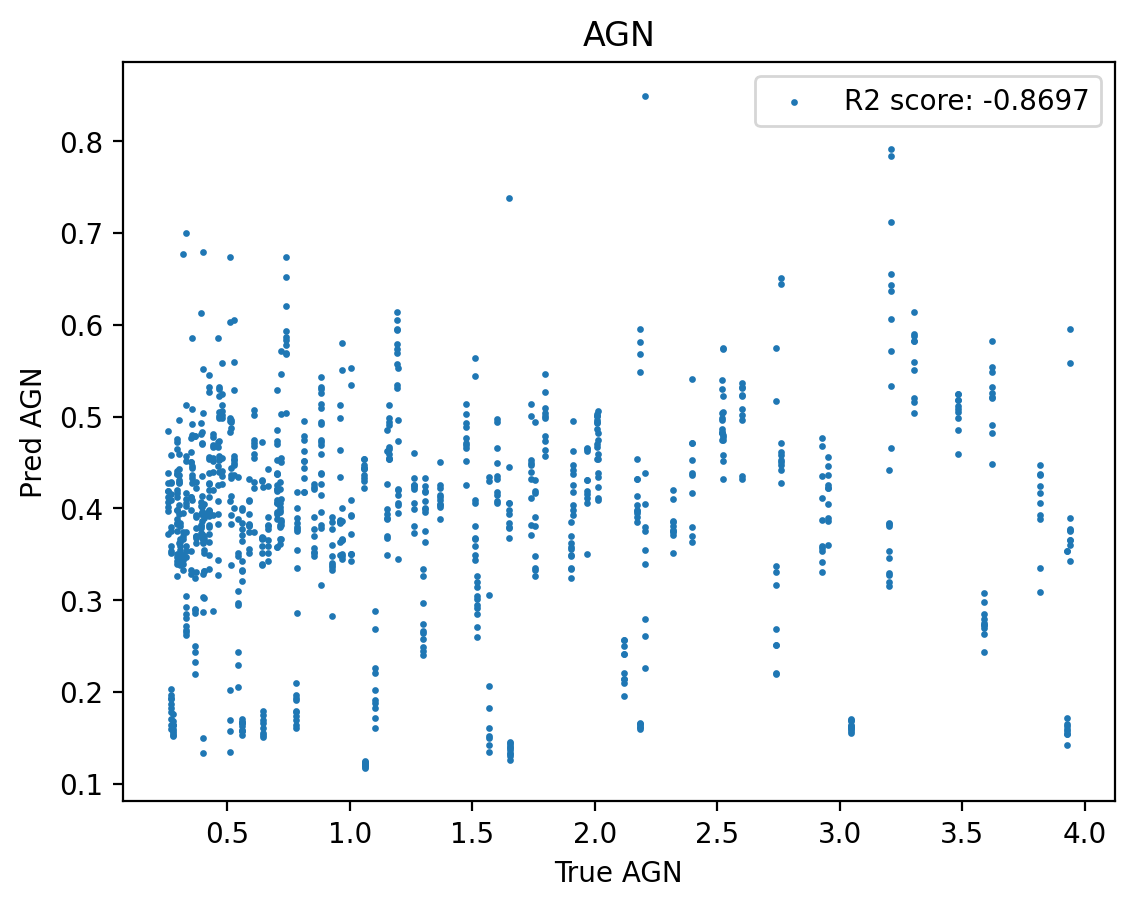

In [55]:
plt.figure(dpi = dpi)
plt.scatter(agn_true, agn_pred, s = 2, label = f"R2 score: {agn_r2}")
plt.xlabel("True AGN")
plt.ylabel("Pred AGN")
plt.legend(loc = "upper right")
plt.title("AGN")
if(save_fig == True):
    plt.savefig('agn' + fig_name)

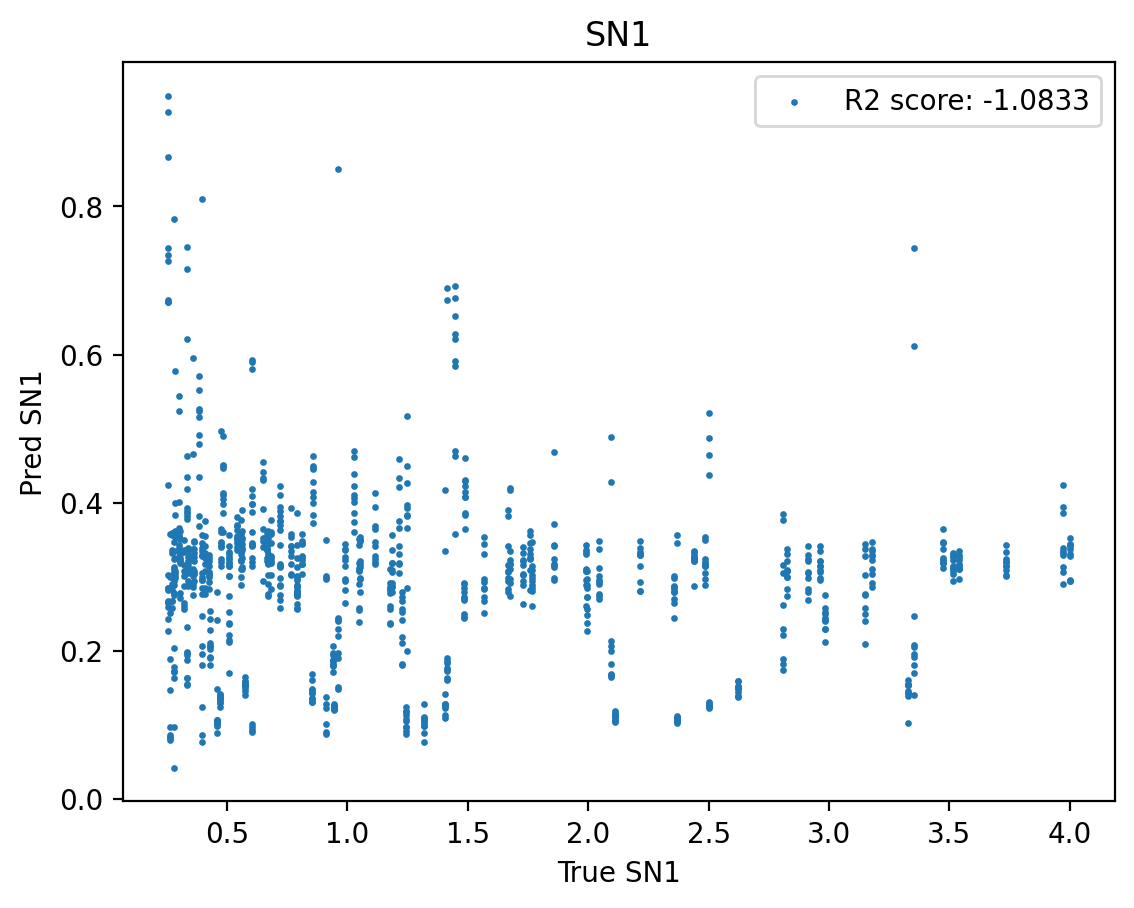

In [56]:
plt.figure(dpi = dpi)
plt.scatter(sn1_true, sn1_pred, s = 2, label = f"R2 score: {sn1_r2}")
plt.xlabel("True SN1")
plt.ylabel("Pred SN1")#f"User pressed the: {k}"
plt.title("SN1")
plt.legend(loc = "upper right")
if(save_fig == True):
    plt.savefig('sn1' + fig_name)

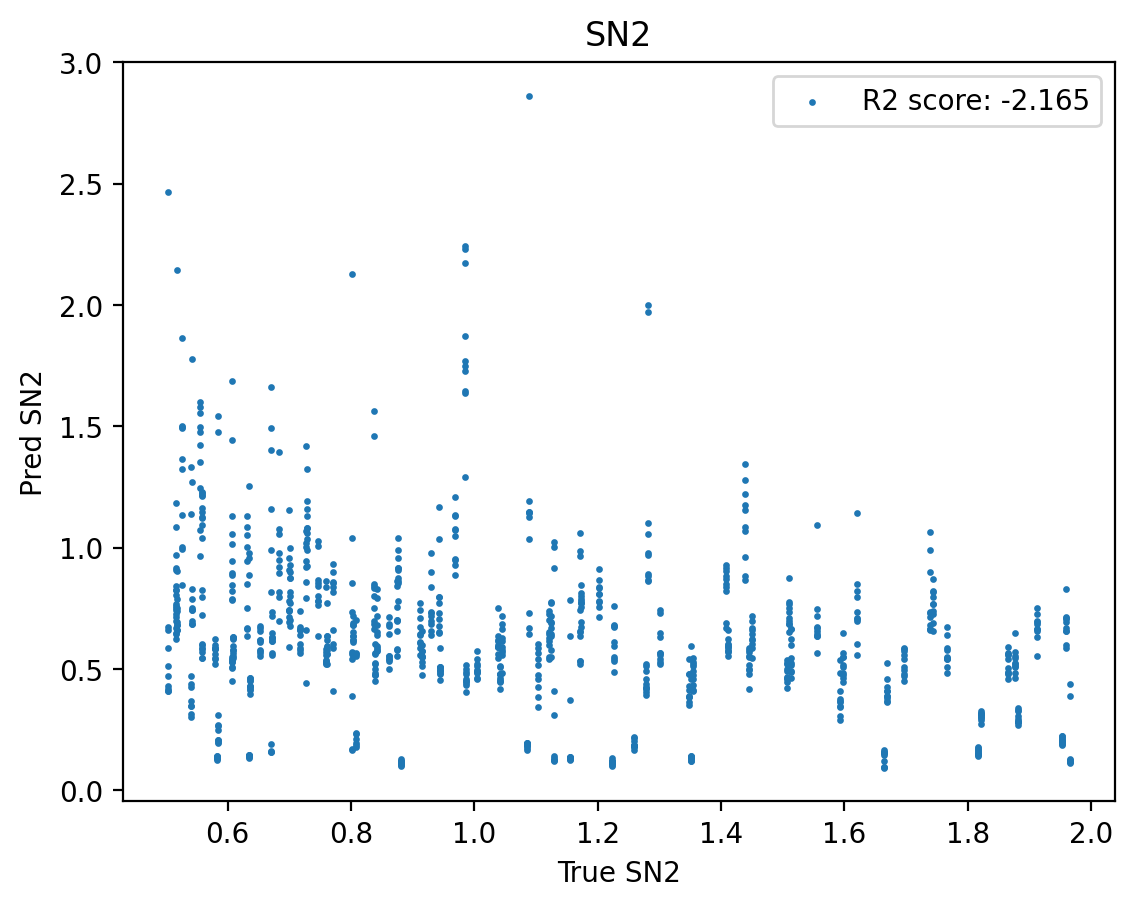

In [57]:
plt.figure(dpi = dpi)
plt.scatter(sn2_true, sn2_pred, s = 2, label = f"R2 score: {sn2_r2}")
plt.xlabel("True SN2")
plt.ylabel("Pred SN2")#f"User pressed the: {k}"
plt.title("SN2")
plt.legend(loc = "upper right")
if(save_fig == True):
    plt.savefig('sn2' + fig_name)